In [40]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors

In [41]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

As we will do a multiple broken power law, from now on the position of the knots will not be a free parameter anymore in order to make the convergence of the fit easier.

In [42]:
def multiple_bpl(xdata, params):
    if knots < 3 or knots > 30: #change this when adding more number of knots
        raise Exception('knots have to be larger or equal than 3 and smaller than 30')
    else:
        polw = np.zeros(len(xdata))
        Es = np.geomspace(xdata[0], xdata[-1], knots)
        lam = np.zeros(knots-1)
        phi = np.zeros(knots-1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        lam0 = params[1]
        sqrtdelta_lam = params[2:knots]
        lam[0] = lam0
        phi[0] = phi_0 * ((1/Es[1]) ** (-lam[0]))
        for i in range(1, knots-1):
            lam[i] = lam[i-1] + ((sqrtdelta_lam[i-1]) ** 2)
            phi[i] = phi[i-1] * ((1/Es[i]) ** (-(sqrtdelta_lam[i-1]) ** 2))
        for i in range(knots-1):
            for j in range(len(xdata)):
                if Es[i] < xdata[j] <= Es[i+1]:
                    polw[j] = phi[i] * ((xdata[j]) ** (-lam[i]))
                elif xdata[j] <= Es[1]:
                    polw[j] = phi[0] * ((xdata[j]) ** (-lam[0]))
                elif xdata[j] > Es[-1]:
                    polw[j] = phi[-2] * ((xdata[j]) ** (-lam[-2]))
    return polw


In [43]:
# least-squares score function = sum of data residuals squared
def LSQ(params):
    return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)

Now we define the function of the fit

In [44]:
def multiple_bpl_fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    m.tol = 1e-20

    m.migrad()
    print(m.values)

    m.hesse()
    print(m.errors)

    return m

Let's check that the program works as intended

In [45]:
file = np.loadtxt('tau_dominguez11.out')

pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})

E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()
logE = np.log10(E)

K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)
SED = np.square(E) * dNdEa
SED_u = SED * 0.1

In [46]:
ydata = SED[3:37]
xdata = E[3:37]
knots = 5
ydata_u = SED_u[3:37]
initial_guess = np.array([5e-7, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = multiple_bpl_fit(initial_guess=initial_guess)

<ValueView x0=5.439335939511715e-07 x1=0.02037510562582874 x2=0.9795923774544655 x3=0.7604525980909134 x4=-9.549702234366559e-09 x5=1.0 x6=1.0 x7=1.0 x8=1.0 x9=1.0 x10=1.0 x11=1.0 x12=1.0 x13=1.0 x14=1.0 x15=1.0 x16=1.0 x17=1.0 x18=1.0 x19=1.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0 x11=0.0 x12=0.0 x13=0.0 x14=0.0 x15=0.0 x16=0.0 x17=0.0 x18=0.0 x19=0.0>


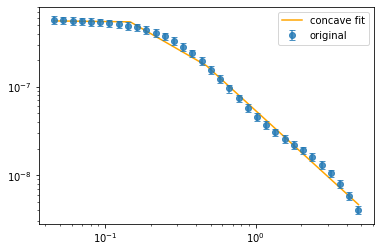

In [47]:
Egam = np.geomspace(E[3],E[36], 300)

plt.plot(Egam, multiple_bpl(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Now let's try it with more realistic data. For that, we will copy the data from the Aeff_bkg_spline.ipynb

In [48]:
fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

In [49]:
fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
Bkgpd = pd.DataFrame(fileBkg)
Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
BckgEdiff = BckgEmax - BckgEmin

BckgElogmean = []
for i in range(len(Bckg)):
    BckgElogmean.append(10**(np.mean([np.log10(BckgEmax[i]), np.log10(BckgEmin[i])])))


Ebinsmin = np.zeros(len(E))
Ebinsmax = np.zeros(len(E))

for i in range(1, len(E)):
    Ebinsmin[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i-1])]))
for i in range(len(E) - 1):
    Ebinsmax[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i+1])]))
    
Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
Ebinsmax[len(E)-1] = 10**(np.log10(Ebinsmax[len(E)-2])-(np.log10(Ebinsmax[len(E)-3])-np.log10(Ebinsmax[len(E)-2])))
Ebinsw = Ebinsmax - Ebinsmin

In [50]:
DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2
def log_interp1d(xx, yy):
    logx = np.log10(xx)
    logy = np.log10(yy)
    interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
    log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
    return log_interp

interpolation = log_interp1d(BckgElogmean,DifBckg)

In [51]:
def trapint(toplim, bottomlim):
    return ((toplim - bottomlim) * (interpolation(toplim) + interpolation(bottomlim)) / 2)

def sqint(toplim, bottomlim):
    return ((toplim - bottomlim) * (interpolation((toplim + bottomlim) / 2)))


In [52]:
newBckgrate = np.zeros([len(E[3:37]),2])
for i in range(len(E[3:37])):
    newBckgrate[i] = quad(interpolation, Ebinsmin[i+3], Ebinsmax[i+3])
newBckgrate = newBckgrate[:,0]

newlogBckg5 = trapint(Ebinsmax[3:37], Ebinsmin[3:37])

newlogBckg6 = sqint(Ebinsmax[3:37], Ebinsmin[3:37])

In [53]:
#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

In [54]:
EffaA2 = np.zeros(len(E[3:37]))
for i in range(len(E[3:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+3] and EffaE[j+10] > E[i+3]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+3] + n

In [55]:
fileAng = np.loadtxt('Angres.txt', skiprows = 11)
Angresall = pd.DataFrame(fileAng)
Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
AngresE= Angresall['E [TeV]'].to_numpy()
Angres = Angresall['Angular resolution (deg)'].to_numpy()

logAngres = np.log10(Angres)
logAngresE = np.log10(AngresE)
logE = np.log10(E)


logAngres2 = np.zeros(len(E[3:37]))
for i in range(len(E[3:37])):
    for j in range(len(AngresE[1:-1])):
        if logAngresE[j+1] < logE[i+3] and logAngresE[j+2] > logE[i+3]:
            m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
            n = logAngres[j+1] - m * logAngresE[j+1]
            logAngres2[i] = m * logE[i+3] + n
Angres2 = 10**logAngres2

In [56]:
def degtorad(ang):
    return ang * np.pi / 180


time = 42480 #42480 #180000#s
skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres2)))#deg^2

bckgmu = newBckgrate * time * skyang

Let's load the Energy resolution curve

In [57]:
fileEres = np.loadtxt('Eres.txt', skiprows = 8)
Eresall = pd.DataFrame(fileEres)
Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
EresE = Eresall['E [TeV]'].to_numpy()
Eres = Eresall['Energy resolution (deg)'].to_numpy()

logEres = np.log10(Eres)
logEresE = np.log10(EresE)
logE = np.log10(E)


logEres2 = np.zeros(len(E[3:37]))
for i in range(len(E[3:37])):
    for j in range(len(EresE[0:-1])):
        if logEresE[j] < logE[i+3] and logEresE[j+1] > logE[i+3]:
            m = (logEres[j+1]-logEres[j])/(logEresE[j+1]-logEresE[j])
            n = logEres[j] - m * logEresE[j]
            logEres2[i] = m * logE[i+3] + n
Eres2 = 10**logEres2
# print(Eres)
# print(Eres2)
# print(AngresE[1:])
# print(E[3:37])

# plt.scatter(EresE, Eres)
# plt.scatter(E[3:37], Eres2)
# plt.xscale('log')
# plt.xlim((0.01,300))

In [58]:
niter = 10
mu = dNdEa[3:37] * EffaA2 * Ebinsw[3:37] * time 
chisqs_iter = []
alphas_iter = []

for j in range(niter):
    my_generator = np.random.default_rng(j)
    Simbckg1 = my_generator.poisson(bckgmu)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu)

    # for i in range(len(N)):
    #     if N[i] == 0:
    #         N[i] = mu[i]
    N_u = np.sqrt(N)
    dNdE_p = dNdEa[3:37] * N/mu
    dNdE_p_u = dNdEa[3:37] * 1/np.sqrt(N)

    Simbckg = (Simbckg1 - Simbckg5) / EffaA2 / Ebinsw[3:37] / time
    Simbckg_u = (Simbckg1_u + Simbckg5_u) / EffaA2 / Ebinsw[3:37] / time


    dNdE_b = dNdE_p + Simbckg
    dNdE_b_u = dNdE_p_u + Simbckg_u
#we need to add the energy resolution here







    SED = np.square(E[3:37]) * dNdE_b
    SED_u = np.square(E[3:37]) * dNdE_b_u

    chisqs = []
    alphas = np.arange(0,2.05,0.05)

    for i in range(41):
        alpha = alphas[i]
        dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
        dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
        SED2 = np.square(E[3:37]) * dNdE2
        SED_u2 = np.square(E[3:37]) * dNdE2_u
        ydata = SED2
        xdata = E[3:37]
        knots =5
        ydata_u = SED_u2
        initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
        things = multiple_bpl_fit(initial_guess=initial_guess)
        chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
        chisqs.append(chi2)
    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

<ValueView x0=5.856193265967323e-07 x1=-0.1160681257659025 x2=-1.137284733354764 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.357770712058378e-07 x1=0.026069931206448634 x2=-0.8918088547106376 x3=-0.8932823014335644 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.370445321245709e-07 x1=0.025068368413198337 x2=-0.8691000873781409 x3=-0.866085457638624 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.382988156154551e-07 x1=0.02410819669281249 x2=-0.8457457420032282 x3=-0.8381830397734615 x4=1.1515073481022824e-07 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0

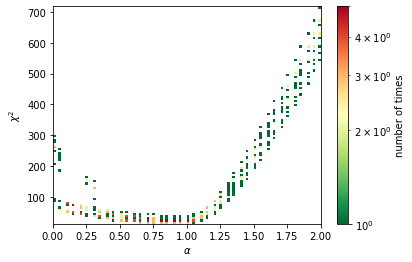

In [59]:
alphas_iter2 = np.concatenate(alphas_iter)
chisqs_iter2 = np.concatenate(chisqs_iter)


fig, ax = plt.subplots()
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=100, norm = colors.LogNorm(), cmap = "RdYlGn_r")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
fig.colorbar(h[3], ax=ax, label="number of times")

In [60]:
niter = 10
mu = dNdEa[3:37] * EffaA2 * Ebinsw[3:37] * time 
chisqs_iter = []
alphas_iter = []

for j in range(niter):
    my_generator = np.random.default_rng(j)
    Simbckg1 = my_generator.poisson(bckgmu)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu)

    # for i in range(len(N)):
    #     if N[i] == 0:
    #         N[i] = mu[i]
    N_u = np.sqrt(N)
    dNdE_p = dNdEa[3:37] * N/mu
    dNdE_p_u = dNdEa[3:37] * 1/np.sqrt(N)

    Simbckg = (Simbckg1 - Simbckg5) / EffaA2 / Ebinsw[3:37] / time
    Simbckg_u = (Simbckg1_u + Simbckg5_u) / EffaA2 / Ebinsw[3:37] / time


    dNdE_b = dNdE_p + Simbckg
    dNdE_b_u = dNdE_p_u + Simbckg_u

    SED = np.square(E[3:37]) * dNdE_b
    SED_u = np.square(E[3:37]) * dNdE_b_u

    chisqs = []
    alphas = np.arange(0.76,1.14,0.02)

    for i in range(19):
        alpha = alphas[i]
        dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
        dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
        SED2 = np.square(E[3:37]) * dNdE2
        SED_u2 = np.square(E[3:37]) * dNdE2_u
        ydata = SED2
        xdata = E[3:37]
        knots =5
        ydata_u = SED_u2
        initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
        things = multiple_bpl_fit(initial_guess=initial_guess)
        chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
        chisqs.append(chi2)
    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

<ValueView x0=5.525564517567939e-07 x1=0.015520117076608594 x2=-0.4718564075370177 x3=-0.37857478748215895 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.52992343809178e-07 x1=0.015328668351935304 x2=-0.4543120122223538 x3=-0.3543287954535767 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.534263471905364e-07 x1=0.015142577476343136 x2=-0.43605719469005555 x3=-0.32834365097990104 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.538584503776921e-07 x1=0.014961621243228687 x2=-0.4169991121443018 x3=-0.300167155089696 x4=-5.314481073299467e-09 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x

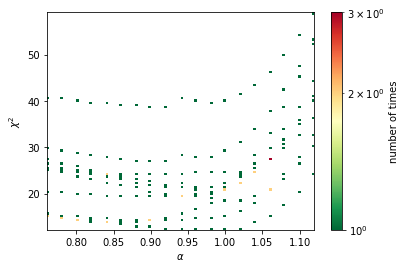

In [61]:
alphas_iter2 = np.concatenate(alphas_iter)
chisqs_iter2 = np.concatenate(chisqs_iter)


fig, ax = plt.subplots()
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=100, norm = colors.LogNorm(), cmap = "RdYlGn_r")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
fig.colorbar(h[3], ax=ax, label="number of times")

<ValueView x0=5.496689143121748e-07 x1=0.03499338990087937 x2=-0.4312164379816277 x3=-0.4405247705765973 x4=1.4344345451390045e-07 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.50109939515681e-07 x1=0.034782506935620135 x2=-0.4119946115687313 x3=-0.4200688971045944 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.505492185074212e-07 x1=0.034576349968999505 x2=-0.3918278310231606 x3=-0.39859673054007877 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.509868250683347e-07 x1=0.03437485544251005 x2=-0.3705623111689784 x3=-0.3759330241222413 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=

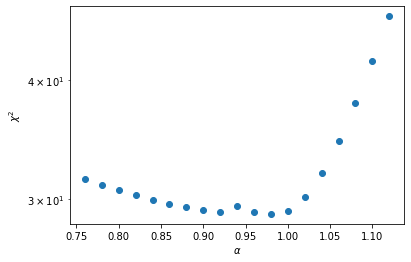

In [64]:
niter = 10
mu = dNdEa[3:37] * EffaA2 * Ebinsw[3:37] * time 
chisqs_iter = []
alphas_iter = []

if True:
    my_generator = np.random.default_rng(106)
    Simbckg1 = my_generator.poisson(bckgmu)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu)

    # for i in range(len(N)):
    #     if N[i] == 0:
    #         N[i] = mu[i]
    N_u = np.sqrt(N)
    dNdE_p = dNdEa[3:37] * N/mu
    dNdE_p_u = dNdEa[3:37] * 1/np.sqrt(N)

    Simbckg = (Simbckg1 - Simbckg5) / EffaA2 / Ebinsw[3:37] / time
    Simbckg_u = (Simbckg1_u + Simbckg5_u) / EffaA2 / Ebinsw[3:37] / time


    dNdE_b = dNdE_p + Simbckg
    dNdE_b_u = dNdE_p_u + Simbckg_u

    SED = np.square(E[3:37]) * dNdE_b
    SED_u = np.square(E[3:37]) * dNdE_b_u

    chisqs = []
    alphas = np.arange(0.76,1.14,0.02)

    for i in range(19):
        alpha = alphas[i]
        dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
        dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
        SED2 = np.square(E[3:37]) * dNdE2
        SED_u2 = np.square(E[3:37]) * dNdE2_u
        ydata = SED2
        xdata = E[3:37]
        knots =5
        ydata_u = SED_u2
        initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
        things = multiple_bpl_fit(initial_guess=initial_guess)
        chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
        chisqs.append(chi2)
    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

plt.plot(alphas, chisqs, 'o')
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()